In [2]:
import numpy as np
import dask , dask.distributed
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean.cm as cmo
import warnings
warnings.simplefilter('ignore')
import dask_jobqueue
from astropy.convolution import Box2DKernel, convolve
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator, LongitudeLocator)
import matplotlib.gridspec as gridspec

In [3]:
ds_corr=xr.load_dataset('/gxfs_work/geomar/smomw577/mesoscale_eddies/BOX_filtered/3x3_boxfilter_ssh_correlations_monthly.nc')
ds_corr_sst=xr.load_dataset('/gxfs_work/geomar/smomw577/mesoscale_eddies/BOX_filtered/3x3_boxfilter_sst_correlations_monthly.nc')


# coarsen grid

In [24]:
###create empty DataArray
grid=xr.zeros_like(ds_corr.corr_ssh_sst)
grid=grid[::20,::20]

In [42]:
ds_corr_coarse=[]
for item in list(ds_corr.keys()):
    coarse=ds_corr[item].interp_like(grid)
    ds_corr_coarse.append(coarse)

In [43]:
ds_corr_sst_coarse=[]
for item in list(ds_corr_sst.keys()):
    coarse=ds_corr_sst[item].interp_like(grid)
    ds_corr_sst_coarse.append(coarse)

In [44]:
ds_corr_coarse=xr.merge(ds_corr_coarse)
ds_corr_sst_coarse=xr.merge(ds_corr_sst_coarse)

# line plots next to corr

## fine

In [10]:
ds_corr_xmean=ds_corr.mean('xt_ocean')
ds_corr_sst_xmean=ds_corr_sst.mean('xt_ocean')

In [47]:
#for SSH
def linemap(var, name, longname):
    fig = plt.figure(figsize=(10,4),layout='compressed')
    gs = gridspec.GridSpec(1, 2, width_ratios=[1,4])
    
    
    ax1 = fig.add_subplot(gs[1],
                     projection=ccrs.PlateCarree(central_longitude=0))
    ds_corr[var].plot.contourf(ax=ax1, vmin=-1, vmax=1, cmap=cmo.balance, #levels=np.linspace(-1,1,3),
                   transform=ccrs.PlateCarree(), add_colorbar=False)
    
    
    gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=1, color='black', alpha=0)
    gl.xlabels_top = False
    gl.ylabels_left = False
    
    ax2 = fig.add_subplot(gs[0])
    ds_corr_xmean[var].where(ds_corr_xmean[var]>=0).plot(ax=ax2, y='yt_ocean', c='firebrick')
    ds_corr_xmean[var].where(ds_corr_xmean[var]<0).plot(ax=ax2, y='yt_ocean', c='royalblue')
    ax2.axvline(0, c='gray', linestyle='--')
    ax2.grid(linewidth=.5);
    ax2.set_ylabel('Latitude')
    ax2.set_xlabel('Correlation')
    
    fig.suptitle('Correlation SSH-'+longname, fontsize=18);
    plt.tight_layout()
    plt.savefig('/gxfs_home/geomar/smomw577/plots/Boxcar/correlations/linemap/3x3_boxcar_linemap_contourf_coarse_ssh_'+name+'_monthly.png', bbox_inches="tight", dpi=300)

In [ ]:
linemap('corr_ssh_sh', 'sh', 'sensible heat')
linemap('corr_ssh_lh', 'lh', 'latent heat')
linemap('corr_ssh_o2', 'o2', 'O2')
linemap('corr_ssh_dic', 'co2', 'CO2')
linemap('corr_ssh_sst', 'sst', 'SST')

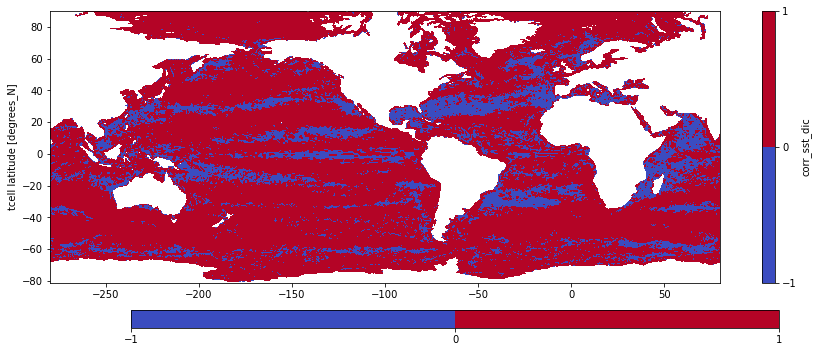

In [3]:
####only for cbar
fig=plt.figure(figsize=(15,5))
im=ds_corr_sst['corr_sst_dic'].plot.contourf(vmin=-1, vmax=1, cmap='coolwarm', levels=np.linspace(-1,1,3))
plt.xlabel('')
cbar_ax = fig.add_axes([0.2, 0.0, 0.6, 0.05])  # Left, bottom, width, height.

cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
plt.savefig('/gxfs_home/geomar/smomw577/plots/Boxcar/correlations/linemap/cmap_2.png', bbox_inches="tight", dpi=300)

In [13]:
#for SSH
def linemap_SST(var, name, longname):
    fig = plt.figure(figsize=(10,4),layout='compressed')
    gs = gridspec.GridSpec(1, 2, width_ratios=[1,4])
    
    
    ax1 = fig.add_subplot(gs[1],
                     projection=ccrs.PlateCarree(central_longitude=0))
    ds_corr_sst[var].plot.contourf(ax=ax1, vmin=-1, vmax=1, cmap='coolwarm', levels=np.linspace(-1,1,3),
                   transform=ccrs.PlateCarree(), add_colorbar=False)
    
    
    gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=1, color='black', alpha=0)
    gl.xlabels_top = False
    gl.ylabels_left = False
    
    ax2 = fig.add_subplot(gs[0])
    ds_corr_sst_xmean[var].where(ds_corr_sst_xmean[var]>=0).plot(ax=ax2, y='yt_ocean', c='firebrick')
    ds_corr_sst_xmean[var].where(ds_corr_sst_xmean[var]<0).plot(ax=ax2, y='yt_ocean', c='royalblue')
    ax2.axvline(0, c='gray', linestyle='--')
    ax2.grid(linewidth=.5);
    ax2.set_ylabel('Latitude')
    ax2.set_xlabel('Correlation')
    
    fig.suptitle('Correlation SST-'+longname, fontsize=18);
    plt.tight_layout()
    plt.savefig('/gxfs_home/geomar/smomw577/plots/Boxcar/correlations/linemap/3x3_boxcar_linemap_contourfmasked_coarse_sst_'+name+'_monthly.png', bbox_inches="tight", dpi=300)

In [ ]:
linemap_SST('corr_sst_sh', 'sh', 'sensible heat')
linemap_SST('corr_sst_lh', 'lh', 'latent heat')
linemap_SST('corr_sst_o2', 'o2', 'O2')
linemap_SST('corr_sst_dic', 'co2', 'CO2')
linemap_SST('corr_sst_ssh', 'ssh', 'SSH')

## coarse

In [46]:
ds_corr_xmean=ds_corr_coarse.mean('xt_ocean')
ds_corr_sst_xmean=ds_corr_sst_coarse.mean('xt_ocean')

In [59]:
#for SSH
def linemap(var, name, longname):
    fig = plt.figure(figsize=(10,4),layout='compressed')
    gs = gridspec.GridSpec(1, 2, width_ratios=[1,4])
    
    
    ax1 = fig.add_subplot(gs[1],
                     projection=ccrs.PlateCarree(central_longitude=0))
    ds_corr_coarse[var].plot.contourf(ax=ax1, vmin=-1, vmax=1, levels=np.linspace(-1,1,3), cmap='coolwarm',
                   transform=ccrs.PlateCarree(), add_colorbar=False)
    
    
    gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=1, color='black', alpha=0)
    gl.xlabels_top = False
    gl.ylabels_left = False
    
    ax2 = fig.add_subplot(gs[0])
    ds_corr_xmean[var].where(ds_corr_xmean[var]>=0).plot(ax=ax2, y='yt_ocean', c='firebrick')
    ds_corr_xmean[var].where(ds_corr_xmean[var]<0).plot(ax=ax2, y='yt_ocean', c='royalblue')
    ax2.axvline(0, c='gray', linestyle='--')
    ax2.grid(linewidth=.5);
    ax2.set_ylabel('Latitude')
    ax2.set_xlabel('Correlation')
    
    fig.suptitle('Correlation SSH-'+longname, fontsize=18);
    plt.tight_layout()
    plt.savefig('/gxfs_home/geomar/smomw577/plots/Boxcar/correlations/linemap/3x3_boxcar_linemap_contourfmasked_coarse_ssh_'+name+'_monthly.png', bbox_inches="tight", dpi=300)

In [60]:
#for SSH
def linemap_SST(var, name, longname):
    fig = plt.figure(figsize=(10,4),layout='compressed')
    gs = gridspec.GridSpec(1, 2, width_ratios=[1,4])
    
    
    ax1 = fig.add_subplot(gs[1],
                     projection=ccrs.PlateCarree(central_longitude=0))
    ds_corr_sst_coarse[var].plot.contourf(ax=ax1, vmin=-1, vmax=1, cmap='coolwarm', levels=np.linspace(-1,1,3),
                   transform=ccrs.PlateCarree(), add_colorbar=False)
    
    
    gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=1, color='black', alpha=0)
    gl.xlabels_top = False
    gl.ylabels_left = False
    
    ax2 = fig.add_subplot(gs[0])
    ds_corr_sst_xmean[var].where(ds_corr_sst_xmean[var]>=0).plot(ax=ax2, y='yt_ocean', c='firebrick')
    ds_corr_sst_xmean[var].where(ds_corr_sst_xmean[var]<0).plot(ax=ax2, y='yt_ocean', c='royalblue')
    ax2.axvline(0, c='gray', linestyle='--')
    ax2.grid(linewidth=.5);
    ax2.set_ylabel('Latitude')
    ax2.set_xlabel('Correlation')
    
    fig.suptitle('Correlation SST-'+longname, fontsize=18);
    plt.tight_layout()
    plt.savefig('/gxfs_home/geomar/smomw577/plots/Boxcar/correlations/linemap/3x3_boxcar_linemap_contourfmasked_coarse_sst_'+name+'_monthly.png', bbox_inches="tight", dpi=300)

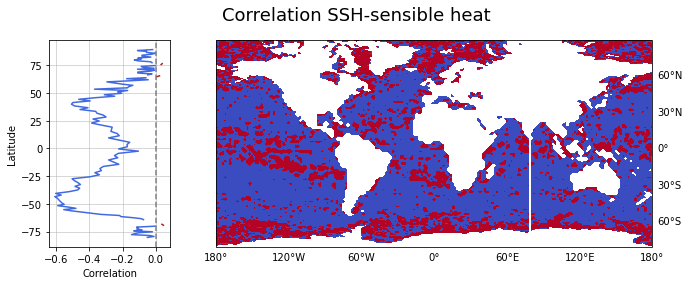

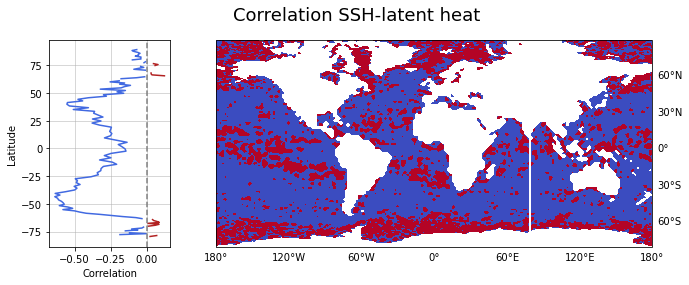

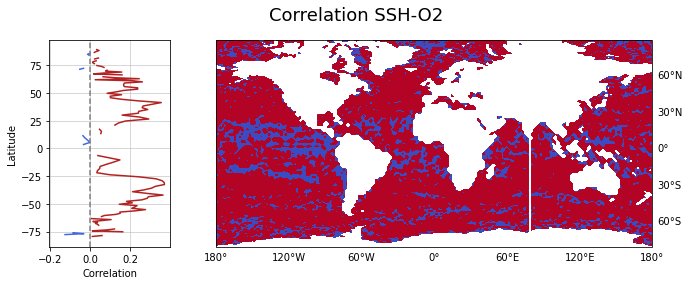

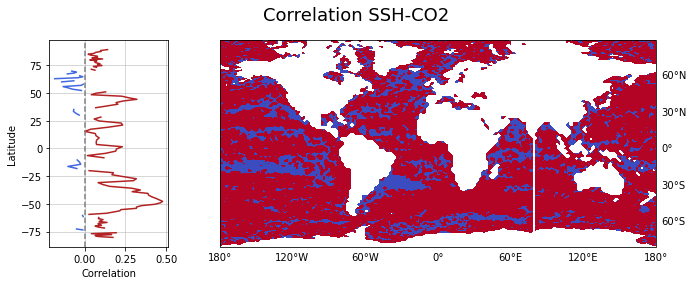

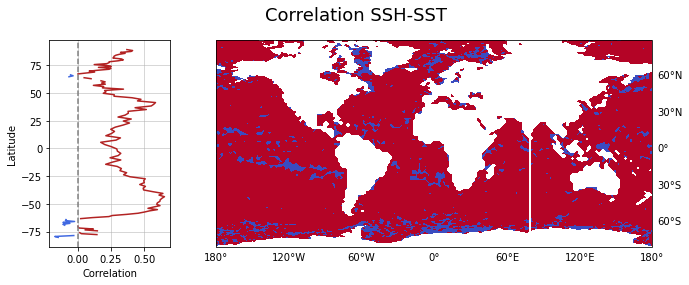

In [61]:
linemap('corr_ssh_sh', 'sh', 'sensible heat')
linemap('corr_ssh_lh', 'lh', 'latent heat')
linemap('corr_ssh_o2', 'o2', 'O2')
linemap('corr_ssh_dic', 'co2', 'CO2')
linemap('corr_ssh_sst', 'sst', 'SST')

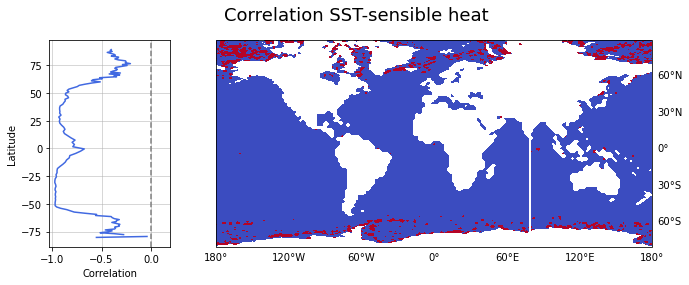

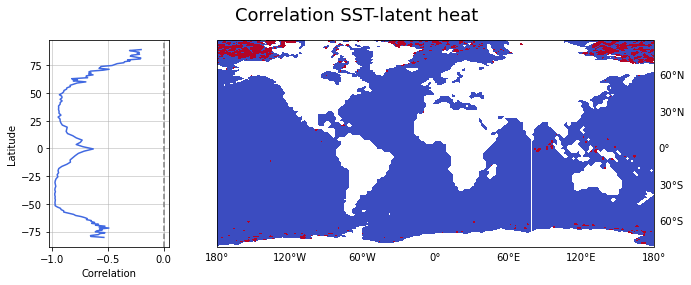

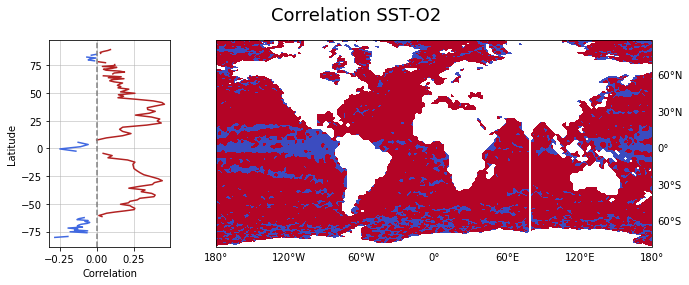

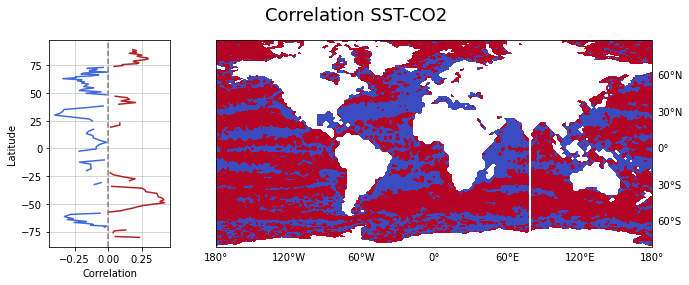

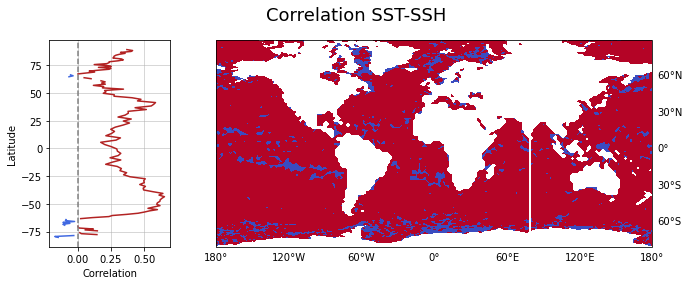

In [56]:
linemap_SST('corr_sst_sh', 'sh', 'sensible heat')
linemap_SST('corr_sst_lh', 'lh', 'latent heat')
linemap_SST('corr_sst_o2', 'o2', 'O2')
linemap_SST('corr_sst_dic', 'co2', 'CO2')
linemap_SST('corr_sst_ssh', 'ssh', 'SSH')

In [ ]:
###need to remove the white line add_cyclic

### to do
- p-value
- masked plots with hatched significance 10% (because only 12 data points)?

In [64]:
import xskillscore

OSError: Could not find/load shared object file